# The idea
The main idea of this project is to simulate the heating of steak in a grid.

# Creating a pixel ADT
Here we define the pixel ADT.\
**Constructor**\
`create_pixel(temperature, thermal_diffusivity_coefficient)` -> pixel\
**Accessors**\
`get_temp(pixel)` -> temperature\
`get_tdc(pixel)` -> thermal diffusivity coefficient

In [1]:
def create_pixel(temperature, thermal_diffusivity_coefficient):
    return (temperature, thermal_diffusivity_coefficient)

def get_temp(pixel):
    return pixel[0]

def get_tdc(pixel):
    return pixel[1]

# Creating a list representing a $m \times n$ (height x width) image
Here we define 3 functions:
1. `create_image` creates a 2-d image of pixel ADTs with `height` rows and `width` columns.
2. `linearise` linearises a 2-d image into a 1-d list.
3. `unlinearise` returns an 2-d image of height `height`.
4. `get_temp_from_image` returns a heatmap of temperatures from a 2-d image of pixel ADTs

In [2]:
import numpy as np
import random

height = 15
width = 20

def create_image(height, width):
    '''
    This function creates a m x n 2-d list that represents
    an image

    args:
    height (int): number of rows of list (which corresponds
    to the height of the image)

    width (int): number of elements in a row (which corresponds
    to the width of the image)
    '''
    res = []
    for i in range(height):
        tmp = []
        for j in range(width):
            if i < 2 * height / 3:
                tmp.append(create_pixel(random.randint(10,20),random.random()))
            else:
                tmp.append(create_pixel(random.randint(80,90),random.random()))
            #let initial temperature be 2, k= 0.1
            # tmp.append(create_pixel(20, 0.1))
        res.append(tmp)
    return res

def linearise(image):
    '''
    This function takes in a m x n 2-d list and returns
    a 1-d array of len m * n

    args:
    image (list): m x n 2-d list
    '''
    res = []
    for i in range(len(image)):
        for j in range(len(image[0])):
            res.append(image[i][j])
    return res

def unlinearise(linearised_image, height):
    '''
    This function takes in a 1-d list of len height * n
    and returns a height x n 2-d list reprenting the image.

    args:
    linearised_picture (list): 1-d list of linearised pixels
    of image
    height (int): number of rows of the image, which corresponds
    to its height
    '''
    n_pixels = len(linearised_image)
    width = n_pixels // height
    if n_pixels % width != 0:
        print("Please enter a valid width!")
        return None
    res = []
    for i in range(height):
        tmp = []
        for j in range(width):
            tmp.append(linearised_image[i * width + j])
        res.append(tmp)
    return res

In [3]:
image = create_image(height,width)
image_lin = linearise(image)
image_unlin = unlinearise(image_lin,len(image))

In [4]:
# Verifying functions
image == image_unlin and len(image_lin) == len(image) * len(image[0])

True

In [5]:
def get_temp_from_image(image):
    '''
    This function takes in an image and returns
    its corresponding heatmap (an array of temperatures)

    args:
    image (list): m x n 2-d list
    '''
    res = []
    for i in range(len(image)):
        tmp = []
        for j in range(len(image[0])):
            tmp.append(get_temp(image[i][j]))
        res.append(tmp)
    return res

def get_k_from_image(image):
    '''
    This function takes in an image and returns
    its corresponding k-array

    args:
    image (list): m x n 2-d list
    '''
    res = []
    for i in range(len(image)):
        tmp = []
        for j in range(len(image[0])):
            tmp.append(get_tdc(image[i][j]))
        res.append(tmp)
    return res

In [6]:
# Verifying function
get_temp_from_image(image)[0][0] == get_temp(image_lin[0])

True

# Plotting the grid
We define 2 functions in this section:
1. `to_color` takes in an integer `temp` and optional `min_temp` and `max_temp` (default 10 and 150 respectively) and returns a rgb array. High temperatures will be presented as redness whereas low temperatures will be presented as blueness.
2. `get_color_map` takes in a 2-d `image` of pixel ADTs and returns a color map based on the temperatures.

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

## Defining heat - color equivalency

In [8]:
def to_color(temp,min_temp = 0, max_temp = 100):
    if temp < min_temp or temp > max_temp:
        print(f"Please enter a temperature between {min_temp} and {max_temp}!")

    # heat_index is a float with values from 0 to 1 showing how hot it is relative
    # to min_temp and max_temp
    heat_index = (temp - min_temp)/(max_temp - min_temp)
    # the color will be red when hot and blue when cool
    color = [heat_index,0.0,1-heat_index]
    return color

In [9]:
to_color(10)

[0.1, 0.0, 0.9]

## Getting a color map

In [10]:
def get_color_map(image):
    image = get_temp_from_image(image)
    res = []
    for i in range(len(image)):
        tmp = []
        for j in range(len(image[0])):
            tmp.append(to_color(image[i][j]))
        res.append(tmp)
    return res

In [11]:
image_color = get_color_map(image)

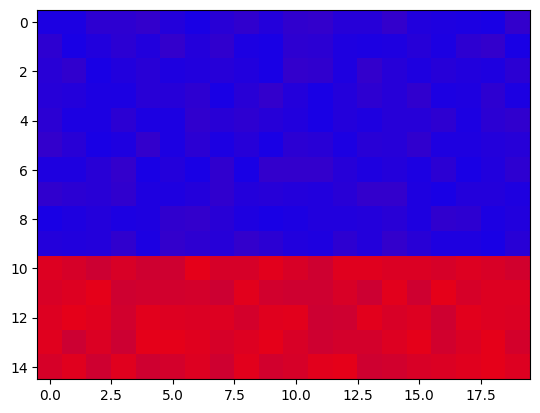

In [12]:
plt.imshow(image_color)

# Changing Temperatures

Here we define a function `kernel` that returns the final temperature of a target pixel after a time duration `t`. It uses the following equation:\
$$ \Delta T = -k_*(T_*-T_{\text{top}}-T_{\text{bottom}}) \times t$$
**HUGE ASSUMPTIONS**
1. Only the top and bottom pixels affect the change in temperature
2. The change in temperature is directly proportional to the negative of the difference in temperatures
3. The mass and specific heat capacity is unity (ie $\Delta T = Q$, where $Q$ is the gain in heat energy)
4. Only the $k$ of the pixel of interest affects its gain of heat.

In [13]:
def kernel(image,i=0,j=0,t=0.1):
    '''
    This function takes in an image and the coordinates
    of the pixel of interest and returns the final temperature (float)
    of the pixel after time t

    args:
    image (list): m x n 2-d list
    i (int): row number of pixel
    j (int): column number of pixel
    t (int): time interval
    '''
    # PART 1: GET THE TOP AND BOTTOM PIXEL DATA
    #     1.1. Transpose to ease slicing
    image_np = np.array(image)
    image_np_T = np.transpose(image_np,(1,0,2)) # swap the first and second axes.
    #     1.2. Access the pixels of interest
    pixel_of_interest = image_np[i,j]
    # account for top row pixels
    # note that bottom row pixels dont need to be accounted for since out of bounds
    # slicing is allowed
    # top row pixels have to be accounted since arr[-1:2] will always return []
    # unless len(arr) == 2, which is a trivial case
    if i == 0:
        pixels_in_contact = np.expand_dims(image_np_T[j,i+1],0) # returns lower pixel.
    else:
        pixels_in_contact = image_np_T[j,i-1:i+2:2] # returns array with upper pixel at index 0, lower at 1

    if j == 0:
        pixels_in_contact = np.concatenate((pixels_in_contact,np.expand_dims(image_np[i,j+1],0)),axis=0) # returns right pixel
    else:
        pixels_in_contact = np.concatenate((pixels_in_contact,image_np[i,j-1:j+2:2]),axis=0) # returns array with left pixel at index 0, right at 1
    
    # PART 2: CALCULATE FINAL TEMP OF PIXEL I,J
    ini_temp_diff = len(pixels_in_contact) * get_temp(pixel_of_interest) - np.array(tuple(get_temp(pixel) for pixel in pixels_in_contact)).sum()
    change_in_temp = -1 * get_tdc(pixel_of_interest) * ini_temp_diff * t
    final_temp = get_temp(pixel_of_interest) + change_in_temp

    
    # Testing

    # print(f"""
    # Pixel of Interest is {pixel_of_interest}
    # N Pixels in Contact is {len(pixels_in_contact)}
    # Pixels in Contact: {pixels_in_contact}
    # Initial Difference in Temperature is {ini_temp_diff}
    # k is {get_tdc(pixel_of_interest)}
    # Change in Temp is {change_in_temp}
    # Final Temp is {final_temp}
    # """)

    
    # return final_temp.item()
    return final_temp

    #notes:
    # add error handling
    # 1. if accessors doesnt work (eg trying to access data from scalar), return error message

In [14]:
# for i in range(len(image)):
#     for j in range(len(image[0])):
#         print(image[i][j],end=" ")
#     print("\n")

In [15]:
def step(image,timestep=0.1):
    height = len(image)
    width = len(image[0])

    res = []
    
    for i in range(height):
        temp_array = []
        for j in range(width):
            step_temperature = kernel(image,i,j,timestep)
            temp_array.append(create_pixel(step_temperature,get_tdc(image[i][j])))
        res.append(temp_array)

    return res

In [16]:
# plt.imshow(get_color_map(step(image)))

Hypothesis:\
The timestep cannot be too big. try to plot a 2 3 grid plots with 2 second differences.\
in the first plot, step the image 20 times (timestep = 0.1)\
in the second plot, step the image 1 time (timestep = 2)

Todo:
1. Create a function that takes in an `image`, `timestep`, `interval`, `total_duration` and outputs a grid with `total_duration / interval` heatmaps
2. Find a way to maintain constant heating

In [17]:
def plot_heatmaps(image,timestep,interval,total_duration):
    n_plots = total_duration / interval
    res = image
    i = 0
    arr_of_images = []
    while i < n_plots:
        print(f"Creating plot no. {i+1} ...")
        j = 0
        while j < (interval / timestep):
            res = step(res,timestep)
            j += 1
        print(f"Plot no. {i+1} created")
        arr_of_images.append(res)
        i += 1
    return arr_of_images

In [18]:
arr = plot_heatmaps(image,0.1,40,200)

Creating plot no. 1 ...
Plot no. 1 created
Creating plot no. 2 ...
Plot no. 2 created
Creating plot no. 3 ...
Plot no. 3 created
Creating plot no. 4 ...
Plot no. 4 created
Creating plot no. 5 ...
Plot no. 5 created


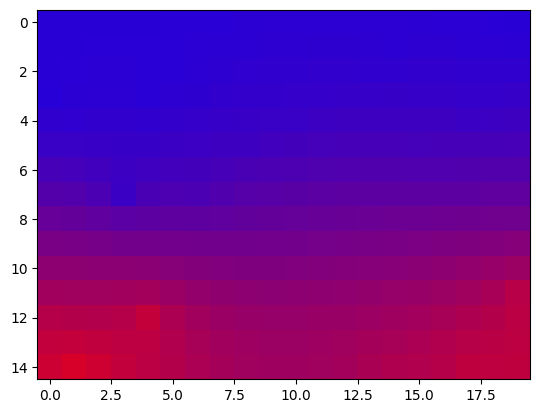

In [19]:
plt.imshow(get_color_map(arr[0]))

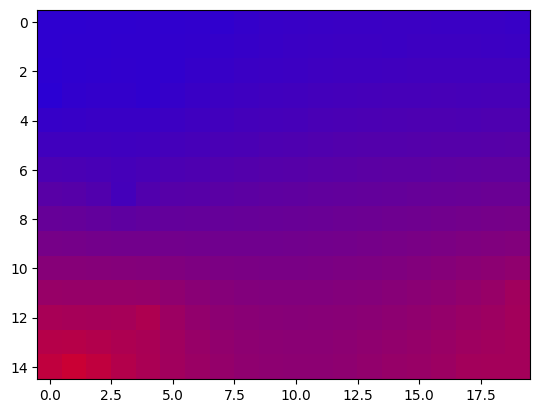

In [20]:
plt.imshow(get_color_map(arr[1]))

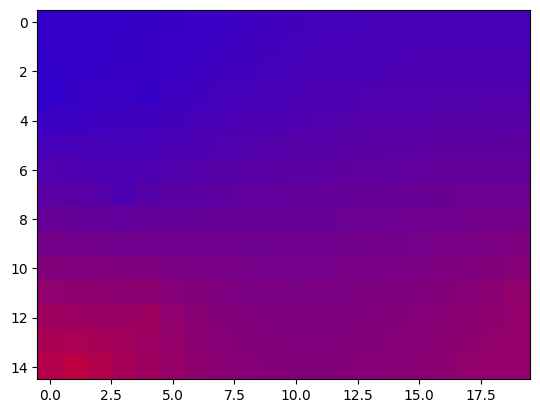

In [21]:
plt.imshow(get_color_map(arr[2]))

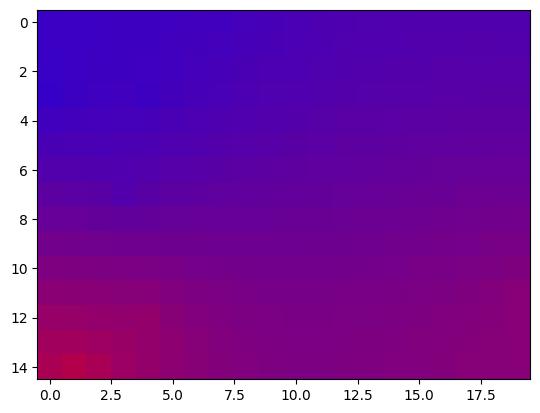

In [22]:
plt.imshow(get_color_map(arr[3]))

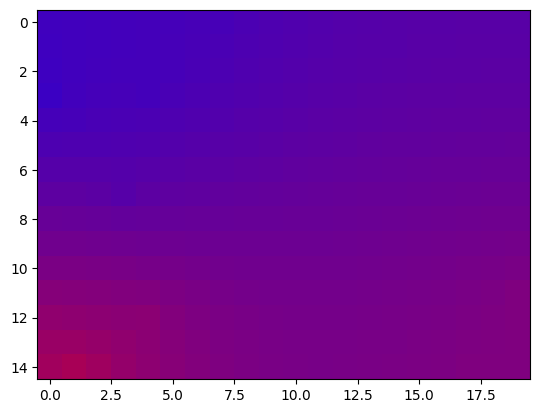

In [23]:
plt.imshow(get_color_map(arr[4]))